### 整体步骤
1. 导入数据
2. 数据预处理
3. 构建G和D网络
4. 建立训练过程
5. 训练
6. 保存模型

### 导入相关包

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import os
import time
import glob
import matplotlib.pyplot as plt
from IPython import display


In [2]:
tf.__version__

'2.2.0'

In [3]:
# 检查GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### 加载数据集

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
# reshape
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
# 像素值调整到[-1,1]
train_images = (train_images - 127.5) / 127.5

In [7]:
# 打印数据集大小
train_images.shape

(60000, 28, 28, 1)

In [8]:
# 批次
BATCH_SIZE = 256

In [9]:
# 构造dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(BATCH_SIZE)

In [10]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

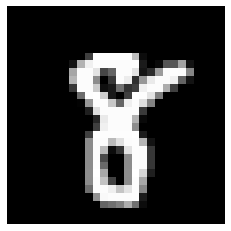

In [48]:
# 预览数据集

for x in train_dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 127.5 + 127.5 )[0],cmap='gray')
    break


In [1]:
# 网络架构

![](./data/model_arc.png)

### 生成器模型

In [11]:
# 构建生成器

G_model = tf.keras.Sequential([
    # 输入向量
    layers.Dense(7*7*256, use_bias=False, input_shape=(100,)) ,
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    # reshape
    layers.Reshape((7, 7, 256)) , #  7x7x256
    #  use_bias=False
    layers.Conv2DTranspose(128, 5, 1,  padding='same' ,use_bias=False), # 7 x 7 x 128
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    # 上采样 
    layers.Conv2DTranspose(64, 5,2, padding='same' , use_bias=False), # 14 x 14 x 64
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    # 缩小通道数
    layers.Conv2DTranspose(1, 5, 2, padding='same', use_bias=False, activation='tanh') # 28 x 28 x 1

])



In [12]:
# 打印网络架构
G_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

### 随机噪声生成一张

In [ ]:
# 随机噪声向量
noise = tf.random.normal([1, 100])
# 输入网络
generated_image = G_model(noise, training=False)
# 显示
plt.imshow(generated_image[0], cmap='gray')

### 判别器模型



In [14]:
# 构建一个 CNN 的图片分类器。
D_model = tf.keras.Sequential([
    # 下采样
    layers.Conv2D(64, 5, 2, padding='same',input_shape=[28, 28, 1]),  # 14 x 14 x 64
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    # 下采样
    layers.Conv2D(128, 5, 2, padding='same'), # 7 x 7 x 128
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    # 拉直
    layers.Flatten(),
    # 判别
    layers.Dense(1) # 1
])


In [15]:
D_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)        

使用未训练的D对所生成的图像进行分类。真实图像输出正值，伪造图像输出负值。

In [16]:
# 将刚才随机生成的输入D网络查看输出结果
decision = D_model(generated_image)
print (decision)

tf.Tensor([[0.499211]], shape=(1, 1), dtype=float32)


## 定义损失函数和优化器

In [17]:
# 使用BCE LOSS函数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
# 优化器
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## 定义训练循环


In [49]:
# 装饰函数以便被调用
@tf.function
def train_step(images):
    
    # 训练判别器
    # 为了记录计算过程，使用梯度带GradientTape
    with tf.GradientTape() as tape:
        # 前传，真实样本判别输出
        real_output = D_model(images, training=True)
        # 构造label
        ones_label = tf.ones_like(real_output)
        # 计算loss
        disc_loss = cross_entropy(ones_label,real_output)
    # 计算梯度    
    gradients_of_discriminator = tape.gradient(disc_loss, D_model.trainable_variables)
    #优化模型，反向传递
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, D_model.trainable_variables))
    
    with tf.GradientTape() as tape:
        # 随机噪音
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        # 前传，伪造的图片
        generated_images = G_model(noise, training=True)
        # 前传，伪造图片的判别输出
        fake_output = D_model(generated_images, training=True)
        # label
        zeros_label = tf.zeros_like(fake_output)
        # 计算loss
        disc_loss = cross_entropy( zeros_label,fake_output)
    # 梯度
    gradients_of_discriminator = tape.gradient(disc_loss, D_model.trainable_variables)
    # 优化模型，反向传递
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, D_model.trainable_variables))
    
    # 训练生成器
    with tf.GradientTape() as tape:
         # 随机噪音
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        # 产生的图片
        generated_images = G_model(noise, training=True)
        # 生成图片的判别输出
        fake_output = D_model(generated_images, training=True)
        # label
        ones_label = tf.ones_like(fake_output)
        # 计算loss
        gen_loss = cross_entropy(ones_label,fake_output )
    # 梯度    
    gradients_of_generator = tape.gradient(gen_loss, G_model.trainable_variables)
    # 优化模型，反向传递
    generator_optimizer.apply_gradients(zip(gradients_of_generator, G_model.trainable_variables))


In [20]:
# 开始训练

In [21]:

EPOCHS = 200
# 输入维度
noise_dim = 100
#希望产生样本数量
num_examples_to_generate = 16
# 随机正态分布噪声
noise_seed = tf.random.normal([num_examples_to_generate, noise_dim])

第1个Epoch训练时间:20.03965973854065 s


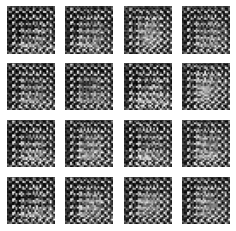

第2个Epoch训练时间:17.828113555908203 s


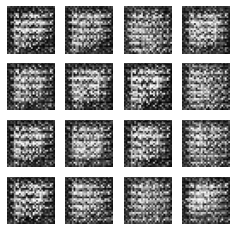

第3个Epoch训练时间:17.707879066467285 s


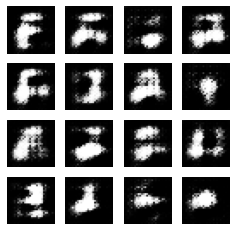

第4个Epoch训练时间:17.607357025146484 s


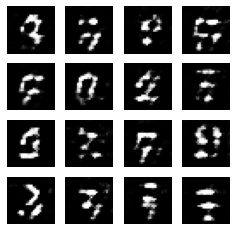

第5个Epoch训练时间:17.783998012542725 s


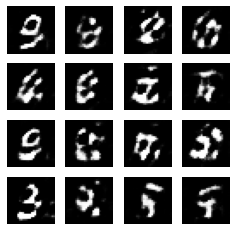

第6个Epoch训练时间:17.74774694442749 s


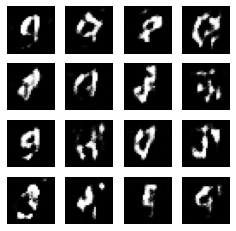

第7个Epoch训练时间:17.883467435836792 s


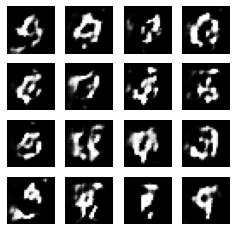

第8个Epoch训练时间:18.198354482650757 s


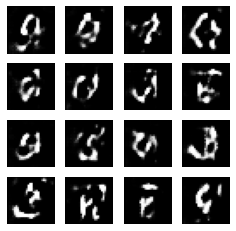

第9个Epoch训练时间:18.234002113342285 s


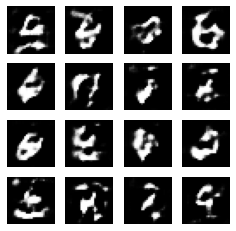

第10个Epoch训练时间:17.591996908187866 s


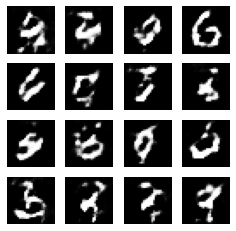

第11个Epoch训练时间:17.60925269126892 s


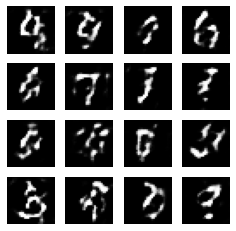

第12个Epoch训练时间:17.606889724731445 s


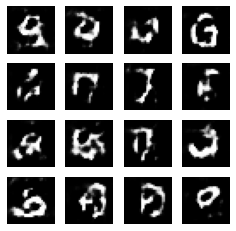

第13个Epoch训练时间:17.601902961730957 s


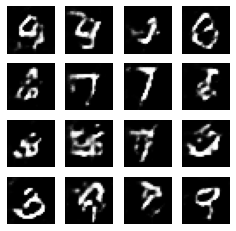

第14个Epoch训练时间:17.602097988128662 s


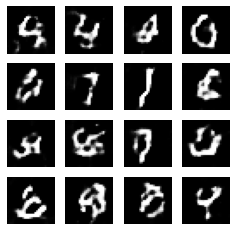

第15个Epoch训练时间:17.610337257385254 s


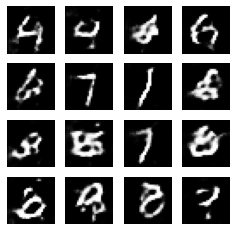

第16个Epoch训练时间:17.62136673927307 s


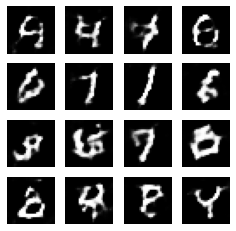

第17个Epoch训练时间:17.645483255386353 s


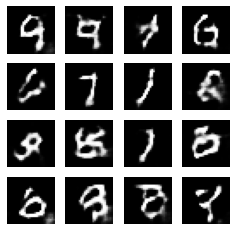

第18个Epoch训练时间:17.633889198303223 s


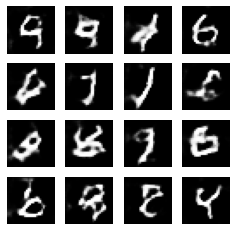

第19个Epoch训练时间:17.654994010925293 s


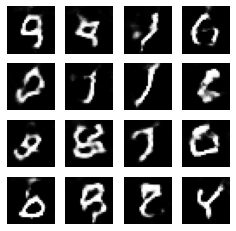

第20个Epoch训练时间:17.657349586486816 s


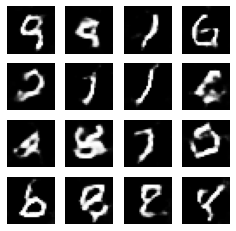

第21个Epoch训练时间:17.64948797225952 s


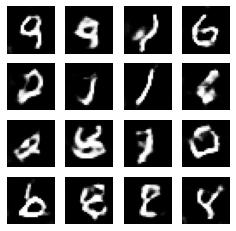

第22个Epoch训练时间:17.640433073043823 s


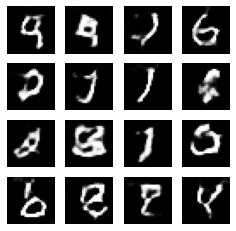

第23个Epoch训练时间:17.659037113189697 s


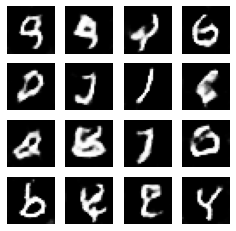

第24个Epoch训练时间:17.630754232406616 s


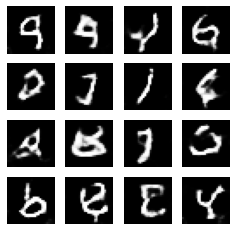

第25个Epoch训练时间:17.632332801818848 s


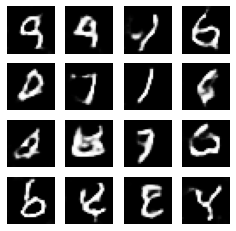

第26个Epoch训练时间:17.641695499420166 s


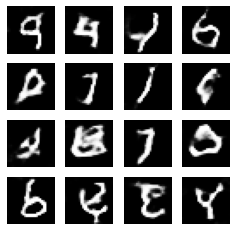

第27个Epoch训练时间:17.642985582351685 s


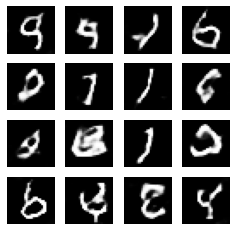

第28个Epoch训练时间:17.64127826690674 s


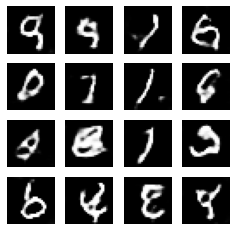

第29个Epoch训练时间:17.644460678100586 s


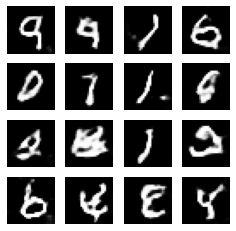

第30个Epoch训练时间:17.645843982696533 s


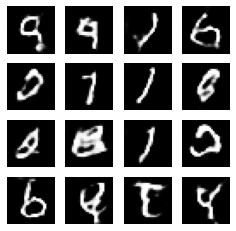

第31个Epoch训练时间:17.649986505508423 s


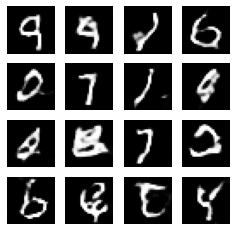

第32个Epoch训练时间:17.631895065307617 s


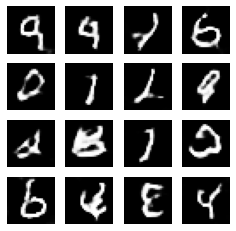

第33个Epoch训练时间:17.645732641220093 s


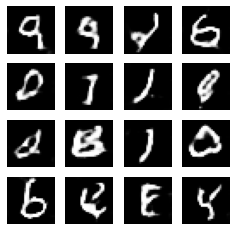

第34个Epoch训练时间:17.64630675315857 s


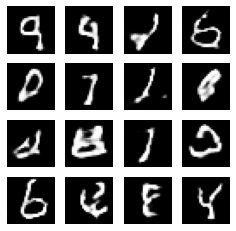

第35个Epoch训练时间:17.64712429046631 s


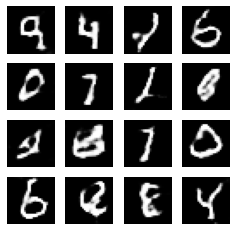

第36个Epoch训练时间:17.656416654586792 s


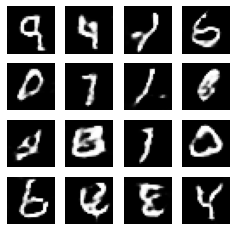

第37个Epoch训练时间:17.636547803878784 s


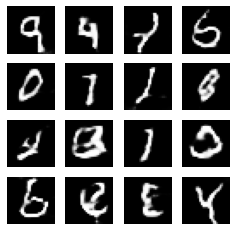

第38个Epoch训练时间:17.6619930267334 s


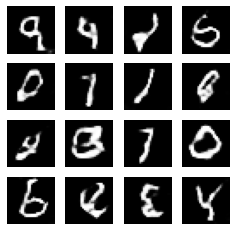

第39个Epoch训练时间:17.64982032775879 s


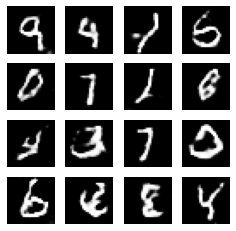

第40个Epoch训练时间:17.652798175811768 s


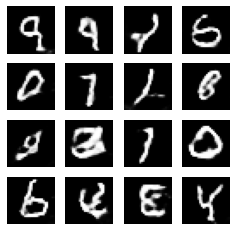

第41个Epoch训练时间:17.647623300552368 s


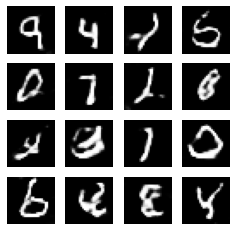

第42个Epoch训练时间:17.65693473815918 s


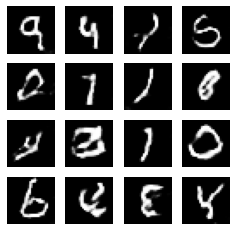

第43个Epoch训练时间:17.645287036895752 s


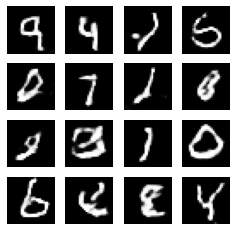

第44个Epoch训练时间:17.64404845237732 s


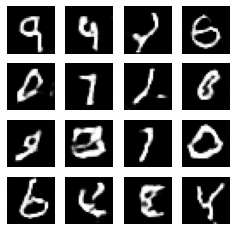

第45个Epoch训练时间:17.65168309211731 s


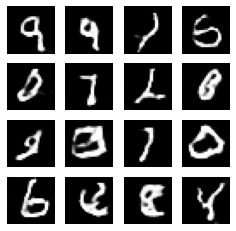

第46个Epoch训练时间:17.64299201965332 s


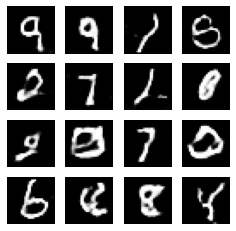

第47个Epoch训练时间:17.637185096740723 s


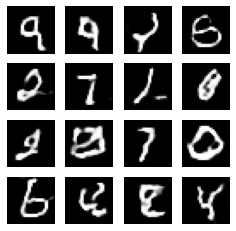

第48个Epoch训练时间:17.639082670211792 s


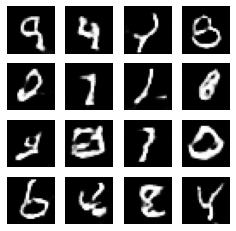

第49个Epoch训练时间:17.63027858734131 s


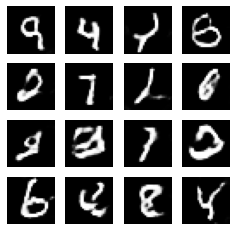

第50个Epoch训练时间:17.655495405197144 s


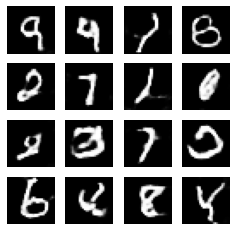

第51个Epoch训练时间:17.64390754699707 s


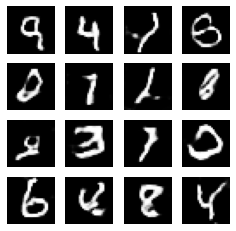

第52个Epoch训练时间:17.638663053512573 s


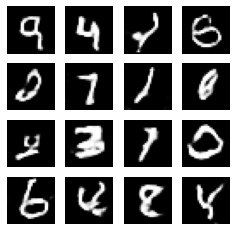

第53个Epoch训练时间:17.6565420627594 s


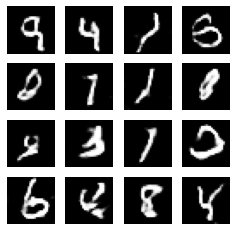

第54个Epoch训练时间:17.65461277961731 s


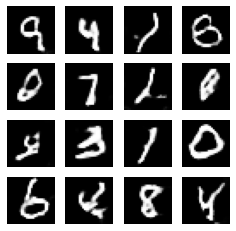

第55个Epoch训练时间:17.635848999023438 s


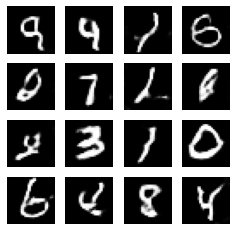

第56个Epoch训练时间:17.642826080322266 s


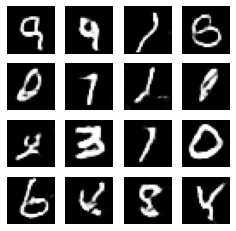

第57个Epoch训练时间:17.644628047943115 s


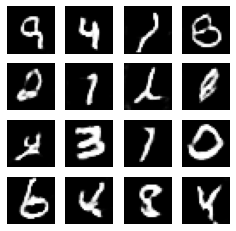

第58个Epoch训练时间:17.652228593826294 s


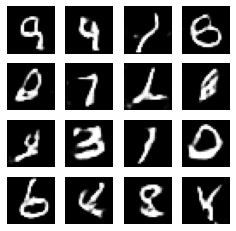

第59个Epoch训练时间:17.639458417892456 s


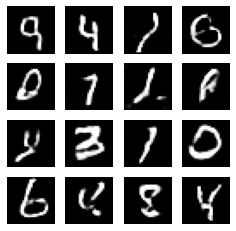

第60个Epoch训练时间:17.648454666137695 s


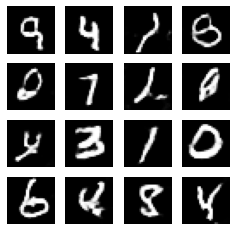

第61个Epoch训练时间:17.646403312683105 s


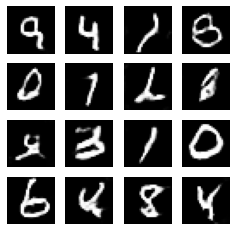

第62个Epoch训练时间:17.63614320755005 s


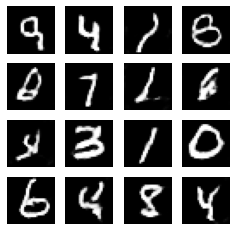

第63个Epoch训练时间:17.649842262268066 s


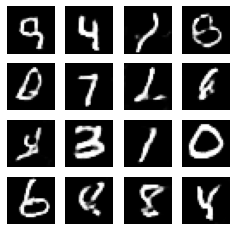

第64个Epoch训练时间:17.640546083450317 s


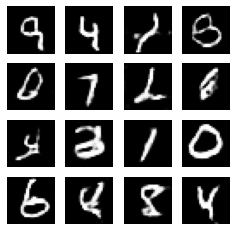

第65个Epoch训练时间:17.6450092792511 s


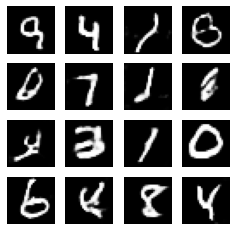

第66个Epoch训练时间:17.65562129020691 s


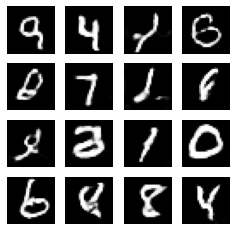

第67个Epoch训练时间:17.64759111404419 s


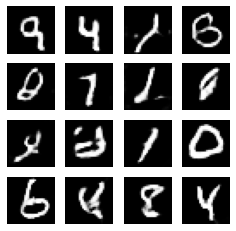

第68个Epoch训练时间:17.658803462982178 s


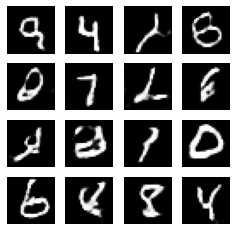

第69个Epoch训练时间:17.64786148071289 s


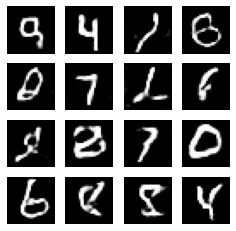

第70个Epoch训练时间:17.6471745967865 s


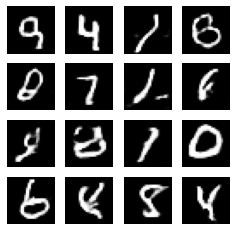

第71个Epoch训练时间:17.653480529785156 s


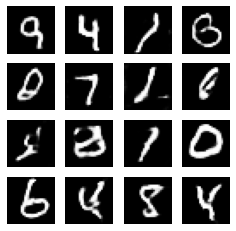

第72个Epoch训练时间:17.647872924804688 s


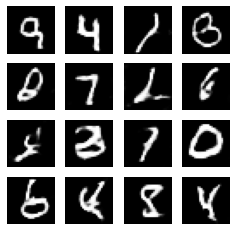

第73个Epoch训练时间:17.6562602519989 s


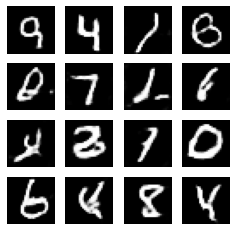

第74个Epoch训练时间:17.65546154975891 s


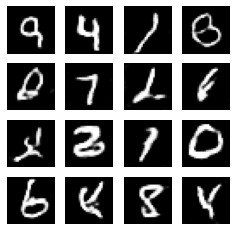

第75个Epoch训练时间:17.660606145858765 s


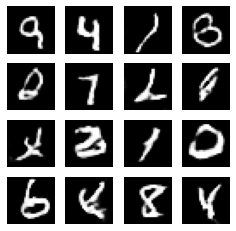

第76个Epoch训练时间:17.637269973754883 s


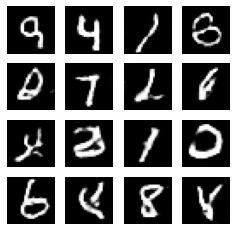

第77个Epoch训练时间:17.645800590515137 s


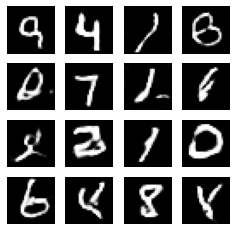

第78个Epoch训练时间:17.64911150932312 s


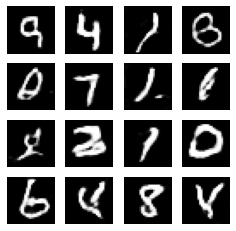

第79个Epoch训练时间:17.653621196746826 s


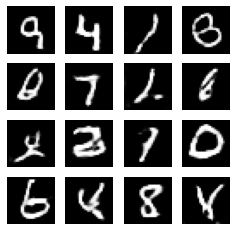

第80个Epoch训练时间:17.65355682373047 s


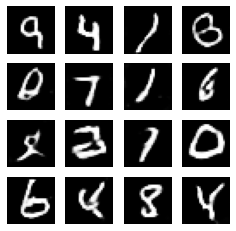

第81个Epoch训练时间:17.654181480407715 s


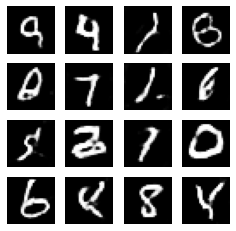

第82个Epoch训练时间:17.64320945739746 s


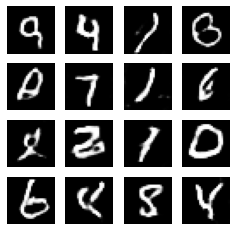

第83个Epoch训练时间:17.65574550628662 s


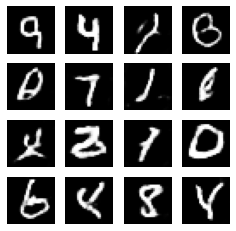

第84个Epoch训练时间:17.645999431610107 s


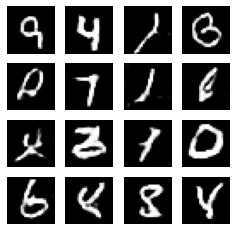

第85个Epoch训练时间:17.660399198532104 s


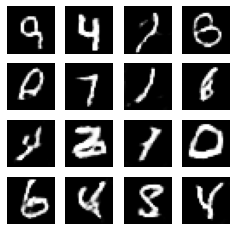

第86个Epoch训练时间:17.644295692443848 s


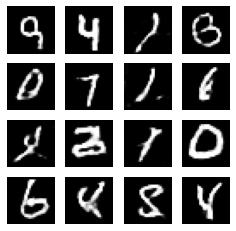

第87个Epoch训练时间:17.655503511428833 s


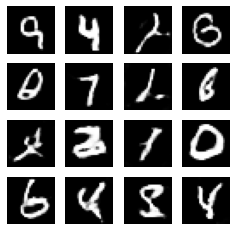

第88个Epoch训练时间:17.640384674072266 s


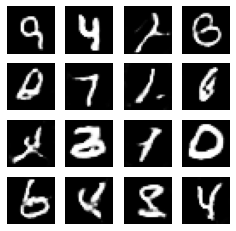

第89个Epoch训练时间:17.653544425964355 s


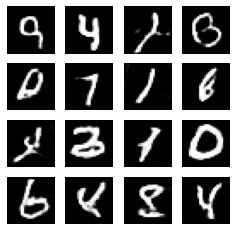

第90个Epoch训练时间:17.650676012039185 s


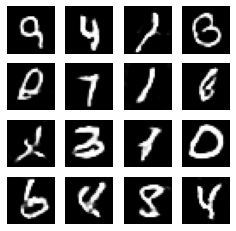

第91个Epoch训练时间:17.642702341079712 s


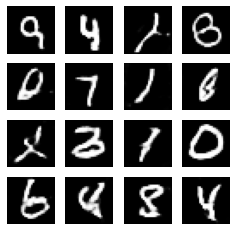

第92个Epoch训练时间:17.65570330619812 s


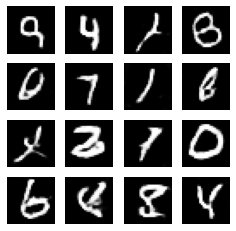

第93个Epoch训练时间:17.650851726531982 s


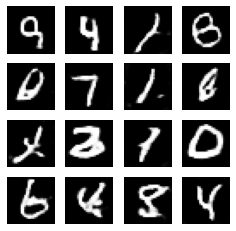

第94个Epoch训练时间:17.658724308013916 s


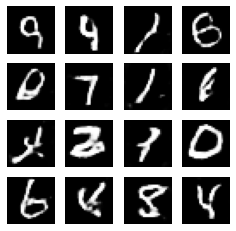

第95个Epoch训练时间:17.64738917350769 s


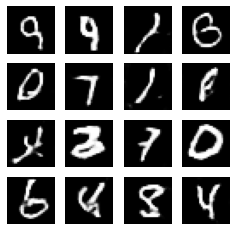

第96个Epoch训练时间:17.650668382644653 s


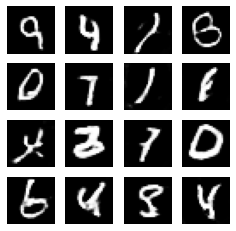

第97个Epoch训练时间:17.64276432991028 s


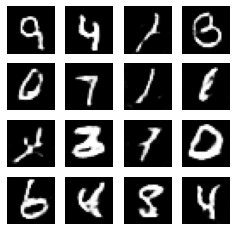

第98个Epoch训练时间:17.647920608520508 s


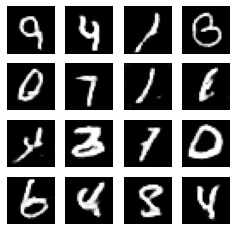

第99个Epoch训练时间:17.637127161026 s


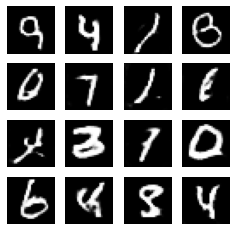

第100个Epoch训练时间:17.639899969100952 s


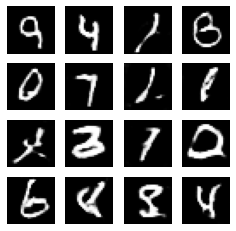

第101个Epoch训练时间:17.651257276535034 s


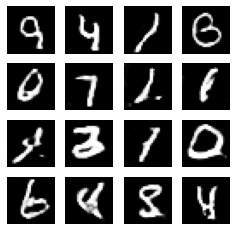

第102个Epoch训练时间:17.65685486793518 s


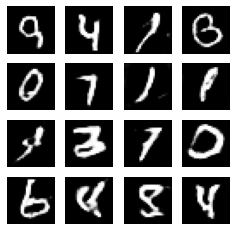

第103个Epoch训练时间:17.626538515090942 s


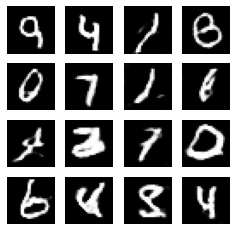

第104个Epoch训练时间:17.64757752418518 s


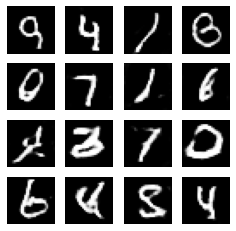

第105个Epoch训练时间:17.640273094177246 s


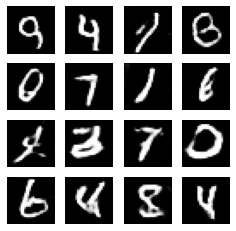

第106个Epoch训练时间:17.65415620803833 s


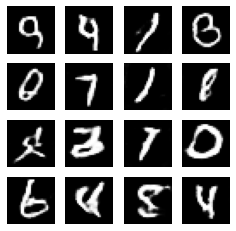

第107个Epoch训练时间:17.65143895149231 s


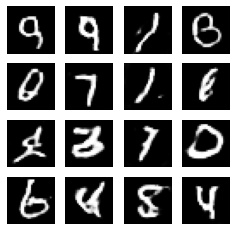

第108个Epoch训练时间:17.646023988723755 s


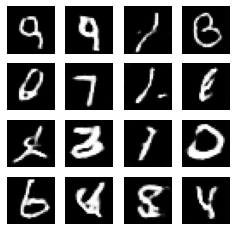

第109个Epoch训练时间:17.637189626693726 s


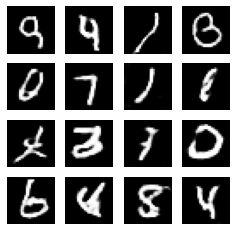

第110个Epoch训练时间:17.63361692428589 s


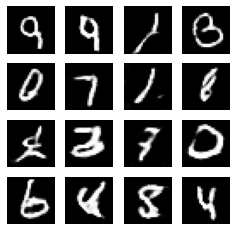

第111个Epoch训练时间:17.654128313064575 s


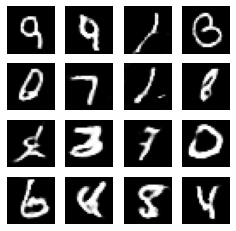

第112个Epoch训练时间:17.644795417785645 s


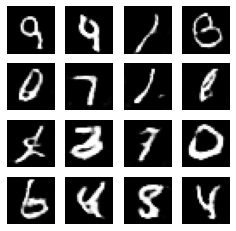

第113个Epoch训练时间:17.6476047039032 s


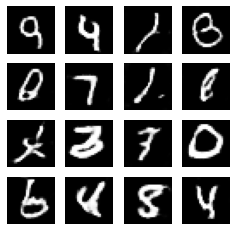

第114个Epoch训练时间:17.652500867843628 s


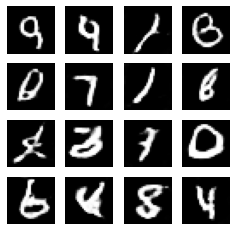

第115个Epoch训练时间:18.15972900390625 s


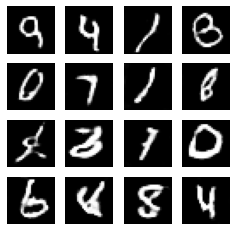

第116个Epoch训练时间:17.998790502548218 s


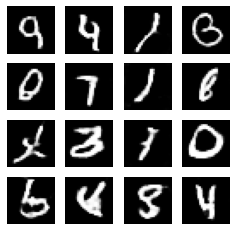

第117个Epoch训练时间:17.674296855926514 s


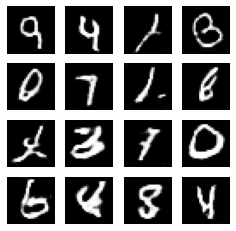

第118个Epoch训练时间:17.637561798095703 s


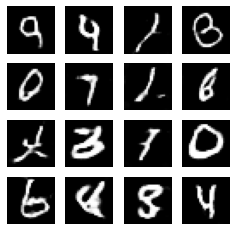

第119个Epoch训练时间:17.624976873397827 s


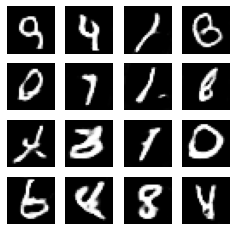

第120个Epoch训练时间:17.645647525787354 s


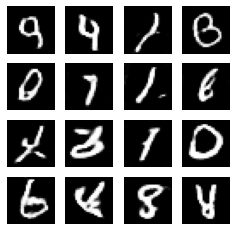

第121个Epoch训练时间:17.631669282913208 s


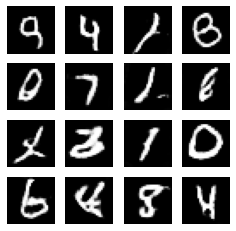

第122个Epoch训练时间:17.634817361831665 s


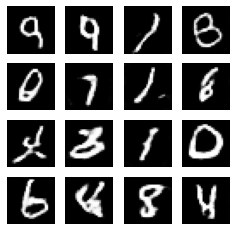

第123个Epoch训练时间:17.648711919784546 s


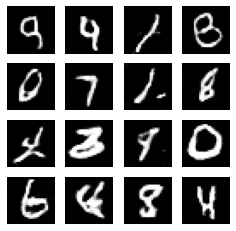

第124个Epoch训练时间:17.64826226234436 s


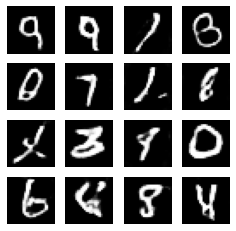

第125个Epoch训练时间:17.647295236587524 s


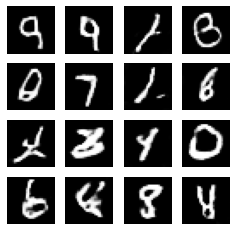

第126个Epoch训练时间:17.656790733337402 s


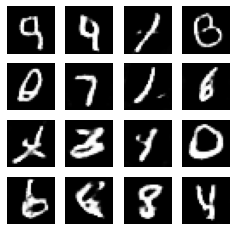

第127个Epoch训练时间:17.641146898269653 s


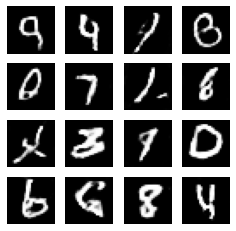

第128个Epoch训练时间:17.702827215194702 s


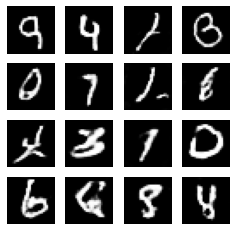

第129个Epoch训练时间:17.643194437026978 s


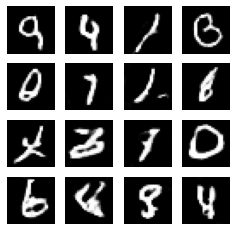

第130个Epoch训练时间:17.646486282348633 s


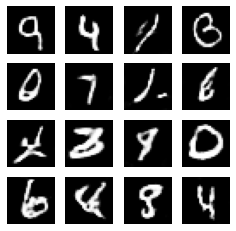

第131个Epoch训练时间:17.633591175079346 s


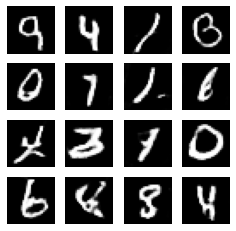

第132个Epoch训练时间:17.827505826950073 s


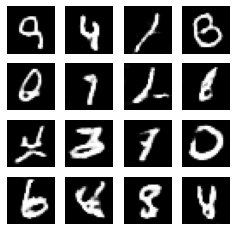

第133个Epoch训练时间:17.772411346435547 s


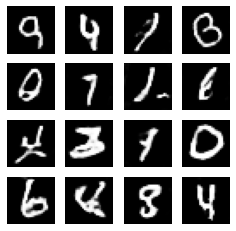

第134个Epoch训练时间:18.16566252708435 s


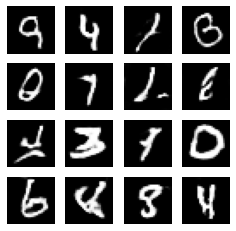

第135个Epoch训练时间:17.746906280517578 s


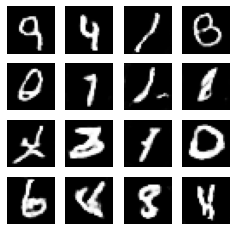

第136个Epoch训练时间:17.79331088066101 s


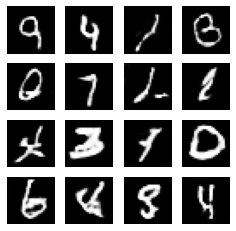

第137个Epoch训练时间:17.67029571533203 s


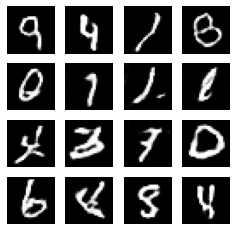

第138个Epoch训练时间:17.69674801826477 s


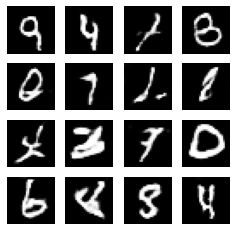

第139个Epoch训练时间:18.164394855499268 s


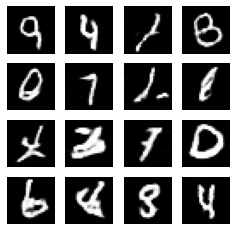

第140个Epoch训练时间:18.32140851020813 s


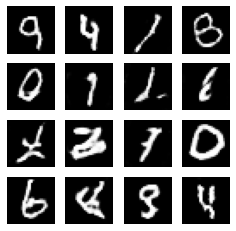

第141个Epoch训练时间:17.96043872833252 s


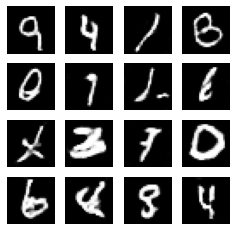

第142个Epoch训练时间:18.256948232650757 s


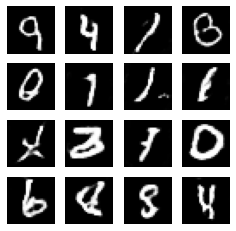

第143个Epoch训练时间:18.503093719482422 s


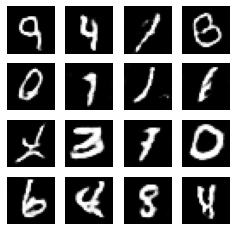

第144个Epoch训练时间:18.088317155838013 s


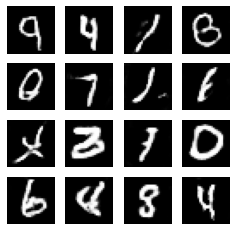

第145个Epoch训练时间:18.173364639282227 s


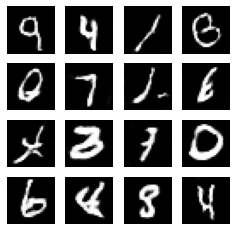

第146个Epoch训练时间:18.119155168533325 s


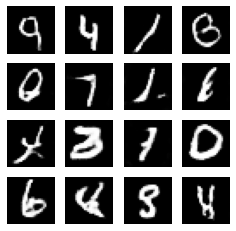

第147个Epoch训练时间:17.82750916481018 s


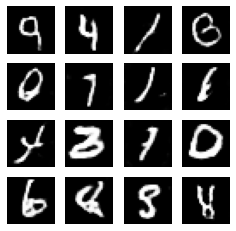

第148个Epoch训练时间:17.859631299972534 s


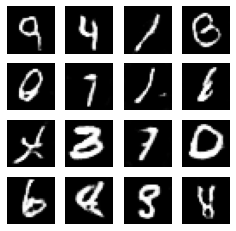

第149个Epoch训练时间:17.78194308280945 s


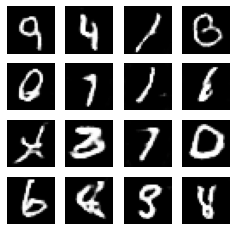

第150个Epoch训练时间:17.827656030654907 s


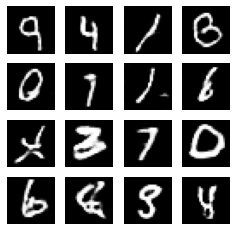

第151个Epoch训练时间:17.992644548416138 s


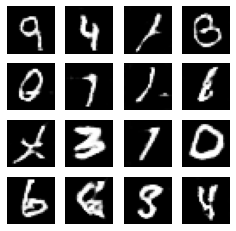

第152个Epoch训练时间:17.825432777404785 s


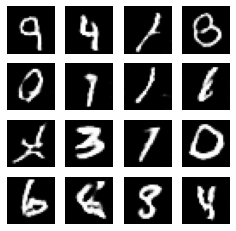

第153个Epoch训练时间:17.820190906524658 s


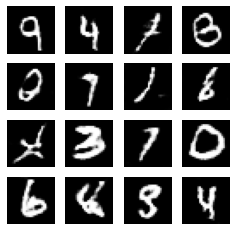

第154个Epoch训练时间:17.7753484249115 s


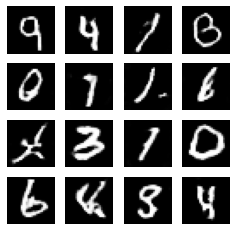

第155个Epoch训练时间:17.73754072189331 s


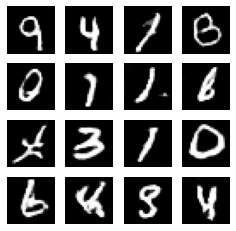

第156个Epoch训练时间:17.833417892456055 s


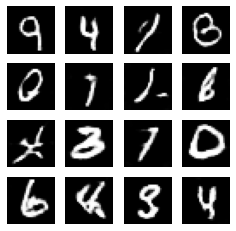

第157个Epoch训练时间:17.815568685531616 s


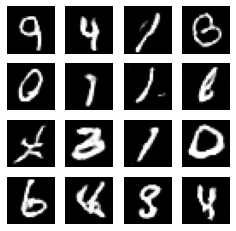

第158个Epoch训练时间:17.754178285598755 s


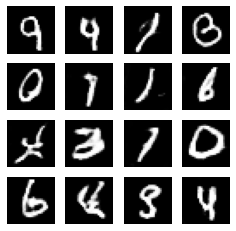

第159个Epoch训练时间:17.776185989379883 s


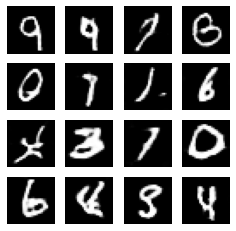

第160个Epoch训练时间:17.76167583465576 s


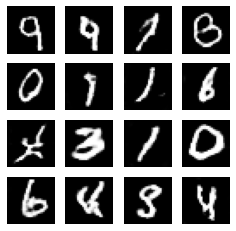

第161个Epoch训练时间:17.82138705253601 s


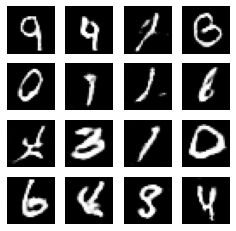

第162个Epoch训练时间:17.779635667800903 s


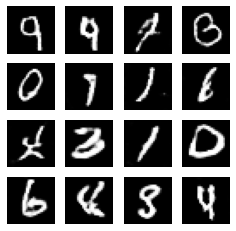

第163个Epoch训练时间:17.969950199127197 s


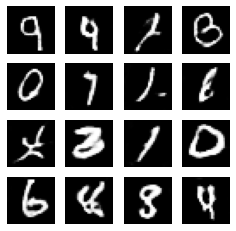

第164个Epoch训练时间:17.878106355667114 s


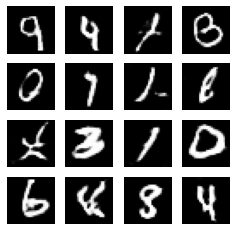

第165个Epoch训练时间:17.828521013259888 s


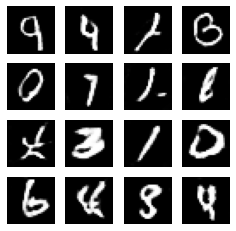

第166个Epoch训练时间:18.17372179031372 s


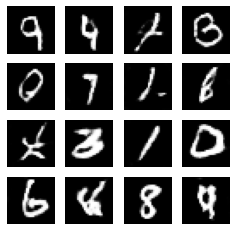

第167个Epoch训练时间:17.7152316570282 s


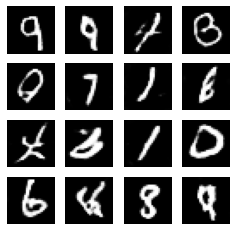

第168个Epoch训练时间:17.845871210098267 s


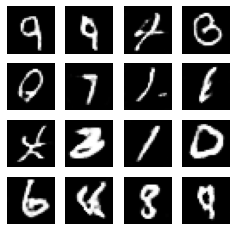

第169个Epoch训练时间:18.09152626991272 s


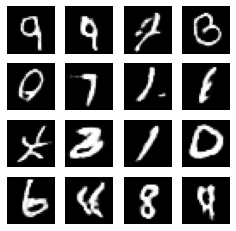

第170个Epoch训练时间:18.158286333084106 s


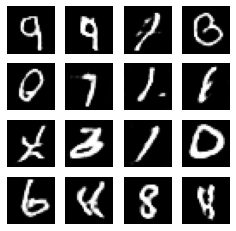

第171个Epoch训练时间:21.05824851989746 s


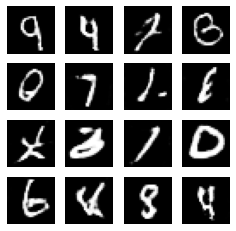

第172个Epoch训练时间:17.73758840560913 s


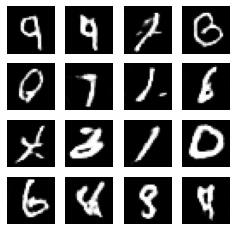

第173个Epoch训练时间:17.829001426696777 s


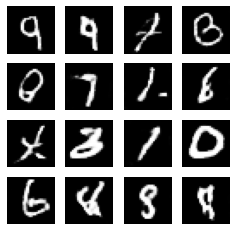

第174个Epoch训练时间:17.691653966903687 s


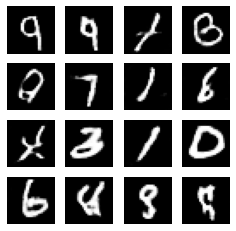

第175个Epoch训练时间:17.63448691368103 s


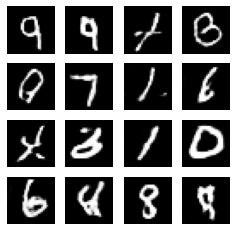

第176个Epoch训练时间:18.707295417785645 s


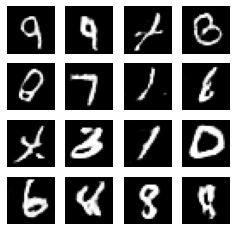

第177个Epoch训练时间:18.54761004447937 s


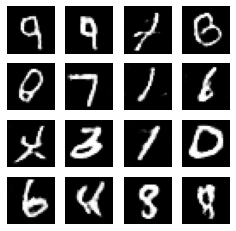

第178个Epoch训练时间:19.568066835403442 s


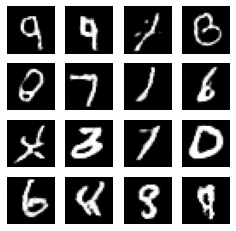

第179个Epoch训练时间:19.15830707550049 s


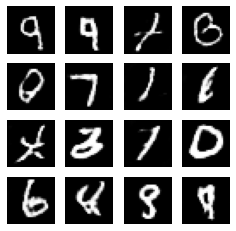

第180个Epoch训练时间:17.72542667388916 s


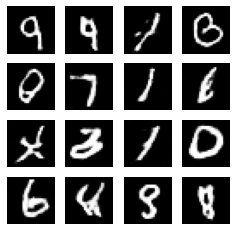

第181个Epoch训练时间:17.799561500549316 s


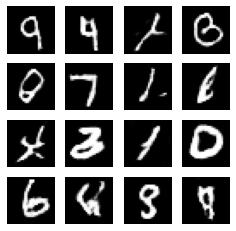

第182个Epoch训练时间:17.624828338623047 s


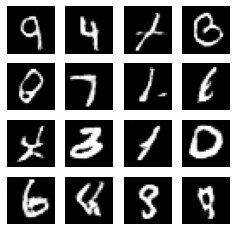

第183个Epoch训练时间:17.998194456100464 s


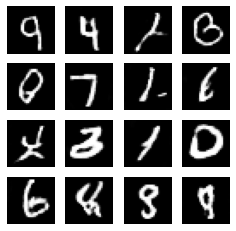

第184个Epoch训练时间:17.63510489463806 s


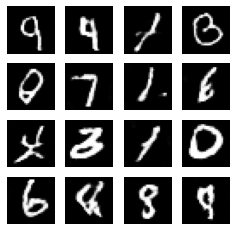

第185个Epoch训练时间:17.90738844871521 s


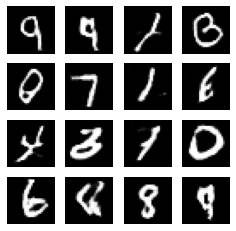

第186个Epoch训练时间:18.565484046936035 s


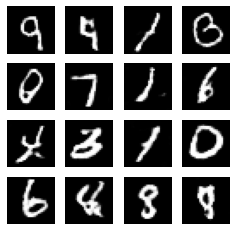

第187个Epoch训练时间:18.741767406463623 s


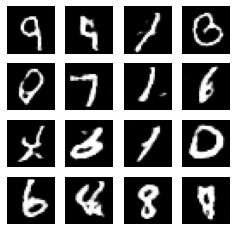

第188个Epoch训练时间:17.748979806900024 s


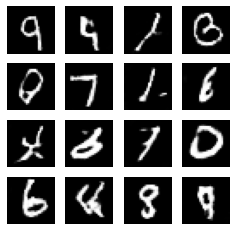

第189个Epoch训练时间:18.032416582107544 s


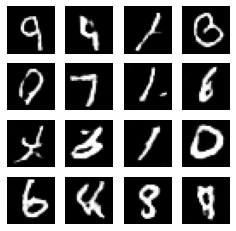

第190个Epoch训练时间:17.943488359451294 s


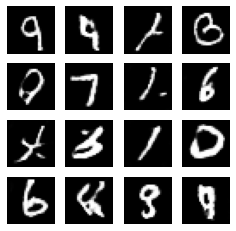

第191个Epoch训练时间:17.772943258285522 s


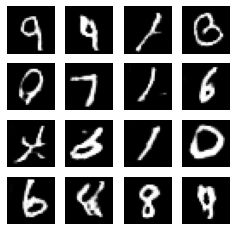

第192个Epoch训练时间:17.93660283088684 s


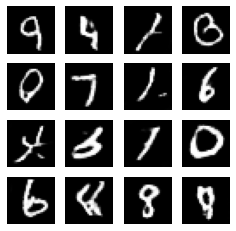

第193个Epoch训练时间:17.851205110549927 s


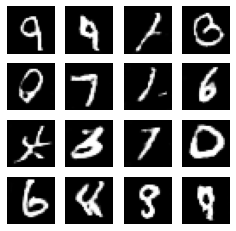

第194个Epoch训练时间:17.871796131134033 s


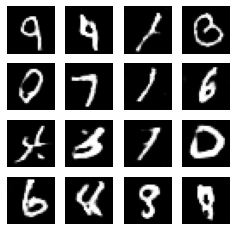

第195个Epoch训练时间:18.277734994888306 s


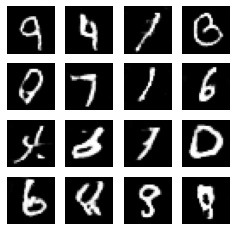

第196个Epoch训练时间:17.69980263710022 s


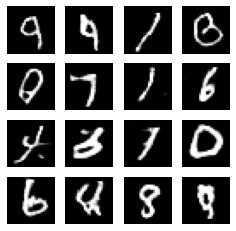

第197个Epoch训练时间:17.658325672149658 s


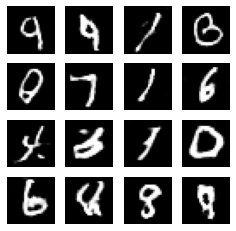

第198个Epoch训练时间:17.65259599685669 s


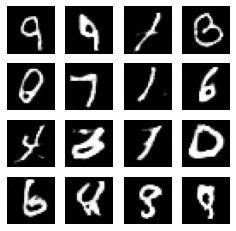

第199个Epoch训练时间:17.730615615844727 s


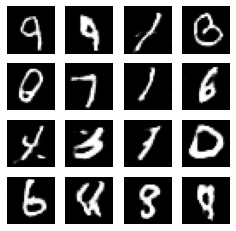

第200个Epoch训练时间:17.648266553878784 s


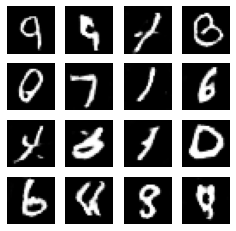

In [ ]:
# 开始训练
for epoch in range(EPOCHS):
    # 遍历dataset
    start_time = time.time()
    for imgs_batch in train_dataset:
        # 训练
        train_step(imgs_batch)
        
    print('第{}个Epoch训练时间:{} s'.format(epoch+1,time.time()-start_time))
    # 显示当前G可以产生的画面，并保存
    predictions = G_model(noise_seed, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i] *127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('gen_minist/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [26]:

# 保存模型
G_model.save('./data/minist_G_model')

INFO:tensorflow:Assets written to: ./data/minist_G_model\assets
